<a href="https://colab.research.google.com/github/annika-lab/waste-classification-and-recommender-system/blob/main/classification_reccommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip garbage_classification_dataset.zip

Archive:  garbage_classification_dataset.zip
  inflating: Multi class garbage classification/labels.txt  
  inflating: Multi class garbage classification/test/cardboard/cardboard108.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard114.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard115.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard116.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard117.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard119.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard12.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard123.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard125.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard127.jpg  
  inflating: Multi class garbage classification/test/cardboard/cardboard129

In [12]:
!unzip E_waste.zip
!ls

Archive:  E_waste.zip
  inflating: E_waste/test/Battery/battery_106.jpg  
  inflating: E_waste/test/Battery/battery_128.jpg  
  inflating: E_waste/test/Battery/battery_148.jpg  
  inflating: E_waste/test/Battery/battery_152.jpg  
  inflating: E_waste/test/Battery/battery_174.jpg  
  inflating: E_waste/test/Battery/battery_177.jpg  
  inflating: E_waste/test/Battery/battery_190.jpg  
  inflating: E_waste/test/Battery/battery_192.jpg  
  inflating: E_waste/test/Battery/battery_211.jpg  
  inflating: E_waste/test/Battery/battery_22.jpg  
  inflating: E_waste/test/Battery/battery_24.jpg  
  inflating: E_waste/test/Battery/battery_241.jpg  
  inflating: E_waste/test/Battery/battery_242.jpg  
  inflating: E_waste/test/Battery/battery_251.jpg  
  inflating: E_waste/test/Battery/battery_259.jpg  
  inflating: E_waste/test/Battery/battery_260.jpg  
  inflating: E_waste/test/Battery/battery_264.jpg  
  inflating: E_waste/test/Battery/battery_266.jpg  
  inflating: E_waste/test/Battery/battery_26

In [13]:
!mkdir ewaste_train_all
!mkdir ewaste_test_all

In [14]:
!cp -r E_waste//train/*/* ewaste_train_all/
!cp -r E_waste//test/*/* ewaste_test_all/

In [15]:
!rm -rf "Multi_class_garbage_classification/train/E_waste"/*
!rm -rf "Multi_class_garbage_classification/test/E_waste"/*

In [16]:
!shuf -n 350 -e ewaste_train_all/* | xargs -I {} cp {} Multi_class_garbage_classification/train/E_waste/
!shuf -n 40 -e ewaste_test_all/* | xargs -I {} cp {} Multi_class_garbage_classification/test/E_waste/
!ls Multi_class_garbage_classification/train/E_waste | wc -l
!ls Multi_class_garbage_classification/test/E_waste/ | wc -l

350
40


In [17]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Multi_class_garbage_classification/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Multi_class_garbage_classification/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 2816 files belonging to 8 classes.
Found 325 files belonging to 8 classes.


In [18]:
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

preprocess_layer = layers.Lambda(preprocess_input)

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

In [20]:
num_classes = 8

inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Lambda(preprocess_input)(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [21]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 185ms/step - accuracy: 0.4902 - loss: 1.4952 - val_accuracy: 0.8031 - val_loss: 0.5475
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.8089 - loss: 0.5705 - val_accuracy: 0.8246 - val_loss: 0.4497
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.8563 - loss: 0.4322 - val_accuracy: 0.8585 - val_loss: 0.4206
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.8749 - loss: 0.3960 - val_accuracy: 0.8677 - val_loss: 0.3318
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.8809 - loss: 0.3555 - val_accuracy: 0.8523 - val_loss: 0.3882


In [23]:
class_names = train_ds.class_names
print(class_names)

['E_waste', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [24]:
model.save("Multi_class_garbage_classification/waste_classifier.keras")

In [25]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9082 - loss: 0.2436
Test Accuracy: 85.23%
Test Loss: 0.3882


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: E_waste
Confidence: 1.00


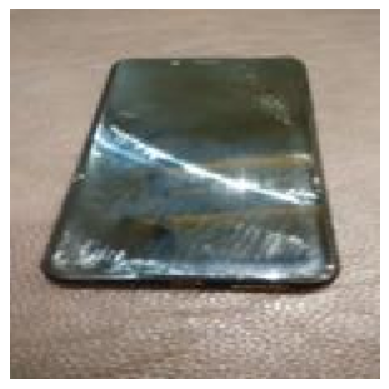

In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


img_path = "Multi_class_garbage_classification/test/E_waste/Mobile_22.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

pred_probs = model.predict(img_array)
pred_class = np.argmax(pred_probs)
confidence = np.max(pred_probs)

print(f"Predicted class: {train_ds.class_names[pred_class]}")
print(f"Confidence: {confidence:.2f}")

plt.imshow(img)
plt.axis("off")
plt.show()

In [31]:
recovery_rules = {
    "cardboard": ["Recycle", "Reuse", "Upcycle"],
    "paper": ["Recycle", "Reuse", "Upcycle"],
    "plastic": ["Recycle", "Reuse", "Upcycle"],
    "metal": ["Recycle", "Reuse", "Repair"],
    "glass": ["Recycle", "Reuse", "Upcycle"],
    "organic": ["Compost", "Biogas", "Reuse"],
    "e-waste": ["Recycle", "Repair", "Reuse"],
    "trash": ["Waste-to-Energy", "Landfill", "Resource Recovery"]
}


In [32]:
def get_valid_paths(predicted_class):
    return recovery_rules.get(predicted_class, ["Landfill"])

get_valid_paths("plastic")

['Recycle', 'Reuse', 'Upcycle']

In [33]:
import pandas as pd
import random

all_options = ["Recycle","Reuse","Upcycle","Repair","Compost","Biogas",
               "Waste-to-Energy","Sanitary Landfill","Resource Recovery"]
data = []
for waste_class in recovery_rules.keys():
    for _ in range(12):
        confidence = round(random.uniform(0.3, 0.99), 2)
        is_clean = random.choice([0,1])
        nearby = random.choice([0,1])

        row = [waste_class, confidence, is_clean, nearby]

        for opt in all_options:
            if opt in all_options:
                if confidence > 0.7 and is_clean==1 and nearby==1:
                    score = 1
                else:
                    score = random.choices([0,1], weights=[0.7,0.3])[0]
            else:
                score = 0
            row.append(score)

        data.append(row)
columns = ["waste_class","confidence","is_clean","nearby_recycler"] + all_options

synthetic_df = pd.DataFrame(data, columns=columns)
synthetic_df = synthetic_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(synthetic_df.head())
print("Total rows:", len(synthetic_df))

  waste_class  confidence  is_clean  nearby_recycler  Recycle  Reuse  Upcycle  \
0     e-waste        0.51         1                1        1      0        0   
1     e-waste        0.59         1                1        0      0        1   
2     e-waste        0.37         0                1        1      0        0   
3       trash        0.62         1                1        0      0        0   
4     plastic        0.67         1                0        0      1        0   

   Repair  Compost  Biogas  Waste-to-Energy  Sanitary Landfill  \
0       0        1       0                0                  0   
1       0        0       0                1                  0   
2       0        1       1                0                  0   
3       0        0       0                0                  0   
4       0        0       0                1                  1   

   Resource Recovery  
0                  1  
1                  1  
2                  0  
3                  1  
4

In [34]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
X_class = synthetic_df[['waste_class']]
ohe = OneHotEncoder()
X_class_encoded = ohe.fit_transform(X_class).toarray()
X_numeric = synthetic_df[['confidence','is_clean','nearby_recycler']].values
X = np.hstack([X_class_encoded, X_numeric])

target_columns = ["Recycle","Reuse","Upcycle","Repair","Compost","Biogas",
                  "Waste-to-Energy","Sanitary Landfill","Resource Recovery"]
y = synthetic_df[target_columns].values

In [35]:
from sklearn.linear_model import LogisticRegression

models = {}
for i, col in enumerate(target_columns):
    clf = LogisticRegression()
    clf.fit(X, y[:, i])
    models[col] = clf

In [36]:
def rank_recovery(waste_class, confidence, is_clean, nearby):
    class_vec = ohe.transform([[waste_class]])

    if hasattr(class_vec, "toarray"):
        class_vec = class_vec.toarray()

    class_vec = np.atleast_2d(class_vec)

    numeric_vec = np.array([[confidence, is_clean, nearby]])

    X_input = np.hstack([class_vec, numeric_vec])

    valid_options = recovery_rules[waste_class]
    scores = {}

    for opt in valid_options:
        model = models[opt]
        score = model.predict_proba(X_input)[0][1]
        scores[opt] = score

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked
rank_recovery("plastic", 0.82, 1, 1)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


[('Upcycle', np.float64(0.5414423927174132)),
 ('Reuse', np.float64(0.4544232814398934)),
 ('Recycle', np.float64(0.38170715729500393))]